In [80]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from scipy import stats

## On measurement

### Concept of measurement
observations that *quantitatively* reduce the uncertainty.

### Object of measurement
Security is vague. decompose it to observable quantities.

### Methods of measurement

Small sample size doesn't mean small statistical significance. 

#### rule-of-five
Given five observations, the possibility that the median of the population is inside the range (min, max) is as high as 93.75%. 

In [10]:
p_inside = (1 - 0.5**5 * 2)  # all the five larger (or lower) than the median of the population

In [11]:
p_inside

0.9375

## Replace risk matrix with quantities

![risk-matrix.png](images/risk-matrix.png)

It can be difficult to make a naively constructed risk matrix consistent, when we put numbers in, i.e., "Medium" cells could have loss larger than "Critical" ones.

In [20]:
data_file = "data/OneforOne-Substitution-Model-30-April-2020-CS-example.xlsx"

In [41]:
from IPython.display import Markdown as md
intro = pd.read_excel(io=data_file, nrows=1, usecols=[4])
intro = intro.iloc[0][0].replace('subjective', '**subjective**')
md(intro)

Introduction: The One-For-One Substitution Model shows how we can replace the basic heat map using purely quantitative methods.  Like the heat map, this approach relies entirely on the **subjective** estimates of likelihood and impact from experts.  Unlike the heat map, it uses mathematically unambiguous probabilistic expressions of likelihood and impact which can be used in simulations where risks can be properly "added up" to compute risks for a larger portfolio. The first tab requires user input. Simply describe the risk or event that is being considered in column B under "Risk Name". Then, estimate the probability that the event will happen over a 1 year period and a 90% confidence interval for the impact of the event, if it did occur. To view the results of the simulation, see the "Loss Exceedance Curve" tab. Make sure that calculation options are set to "Automatic Except for Data Tables" (Formulas>Calculation Options).

In [49]:
data = pd.read_excel(io=data_file, skiprows=8, nrows=4, usecols=[0, 1, 3, 4, 5, 6, 7])
data['prob_accum'] = data['Probability of a Loss Over 1 Year'].cumsum()

In [50]:
data

,Risk ID,Risk Name,Probability of a Loss Over 1 Year,Lower Bound,Upper Bound,Total Cost of Controls,Control Effectiveness,prob_accum
0,1,Data Breach,0.40,500000,10000000,300000,0.35,0.40
1,2,Malware,0.15,2000000,5000000,500000,0.25,0.55
2,3,Lost Laptops,0.35,150000,300000,25000,0.50,0.90
3,4,Pennance Projects,0.10,200000,500000,10000,0.10,1.00


### Monte Carlo simulation

In [124]:
def one_risk_simu(risk_loss):
    """
    One simulation of a loss event - 
     1) generate the risk type with uniform distribution
     2) generate loss assuming a log-normal distribution (stats.lognorm)
    """
    rnd = np.random.rand()
    exp_loss, res_loss = 0, 0
    if rnd < risk_loss['Probability of a Loss Over 1 Year']:
        std = (np.log(risk_loss['Upper Bound']) - 
               np.log(risk_loss['Lower Bound']))/3.29
        mean = (np.log(risk_loss['Upper Bound']) +
                np.log(risk_loss['Lower Bound']))/2.0
        exp_loss = np.exp(stats.norm.rvs(mean, std))
        res_loss = exp_loss * (1-risk_loss['Control Effectiveness'])
    return exp_loss, res_loss

In [137]:
for i, j in zip([one_risk_simu(rl) for ir, rl in data.iterrows()]):
    print(i, j)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
def one_simu_round(data):
    ell, rll = [one_risk_simu(rl) for rl in data.iterrows()]
    zip([one_risk_simu(rl) for ir, rl in data.iterrows()])

In [93]:
def one_simu(data):
    """
    One simulation of a loss event - 
     1) generate the risk type with uniform distribution
     2) generate loss assuming a log-normal distribution (stats.lognorm)
    """
    rnd = np.random.rand()
    for idx, pa in enumerate(data['prob_accum']):
        if rnd < pa:
            risk_id = idx
            break
        
    risk_loss = data.iloc[idx]
    std = (np.log(risk_loss['Upper Bound']) - 
           np.log(risk_loss['Lower Bound']))/3.29
    mean = (np.log(risk_loss['Upper Bound']) +
            np.log(risk_loss['Lower Bound']))/2.0
    exp_loss = np.exp(stats.norm.rvs(mean, std))
    res_loss = exp_loss * (1-risk_loss['Control Effectiveness'])
    return exp_loss, res_loss

In [117]:
n_trial = 10000

losses = [one_simu(data) for i in range(n_trial)]
exp_losses = np.array([l[0] for l in losses])
res_losses = np.array([l[1] for l in losses])

(array([9.525e+03, 3.710e+02, 7.300e+01, 1.800e+01, 7.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([   94887.94733742,  6599092.65758577, 13103297.36783411,
        19607502.07808246, 26111706.7883308 , 32615911.49857915,
        39120116.2088275 , 45624320.91907585, 52128525.62932419,
        58632730.33957253, 65136935.04982088]),
 <BarContainer object of 10 artists>)

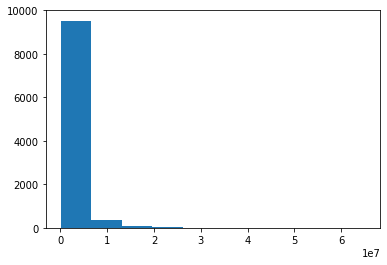

In [118]:
plt.hist(exp_losses)

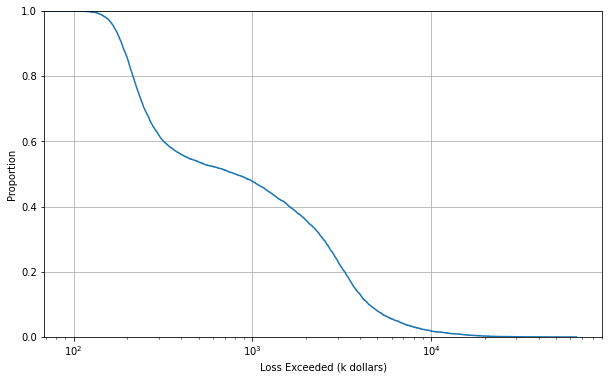

In [119]:
fig, ax = plt.subplots(figsize=(10, 6))
axes = sns.ecdfplot(exp_losses/1000., ax=ax, complementary=True)
ax.set_xscale('log')
ax.set_xlabel('Loss Exceeded (k dollars)')
ax.grid(True)

In [100]:
axes.dataLim

Bbox([[158327.78145452103, 0.0], [22070385.345405705, 1.0]])